# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30478 entries, 0 to 30477
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Host Id                     30478 non-null  int64  
 1   Host Since                  30475 non-null  object 
 2   Name                        30478 non-null  object 
 3   Neighbourhood               30478 non-null  object 
 4   Property Type               30475 non-null  object 
 5   Review Scores Rating (bin)  22155 non-null  float64
 6   Room Type                   30478 non-null  object 
 7   Zipcode                     30344 non-null  float64
 8   Beds                        30393 non-null  float64
 9   Number of Records           30478 non-null  int64  
 10  Number Of Reviews           30478 non-null  int64  
 11  Price                       30478 non-null  object 
 12  Review Scores Rating        22155 non-null  float64
dtypes: float64(4), int64(3), object

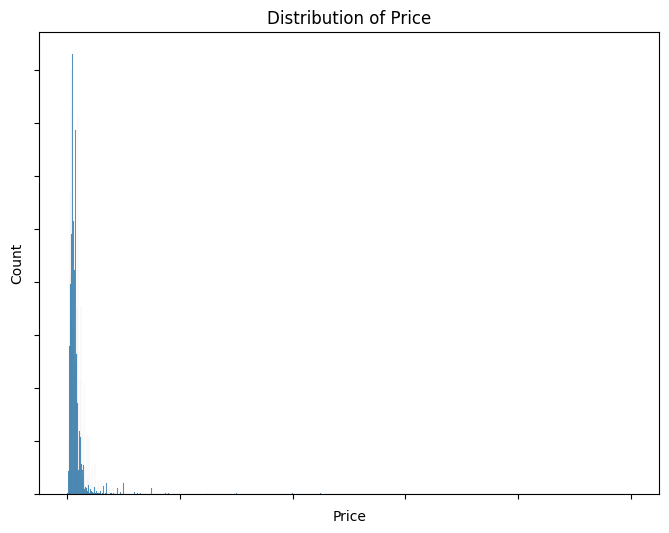

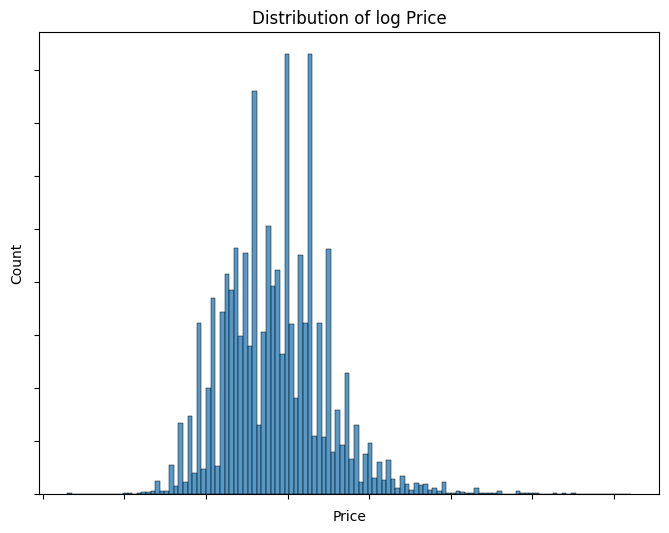

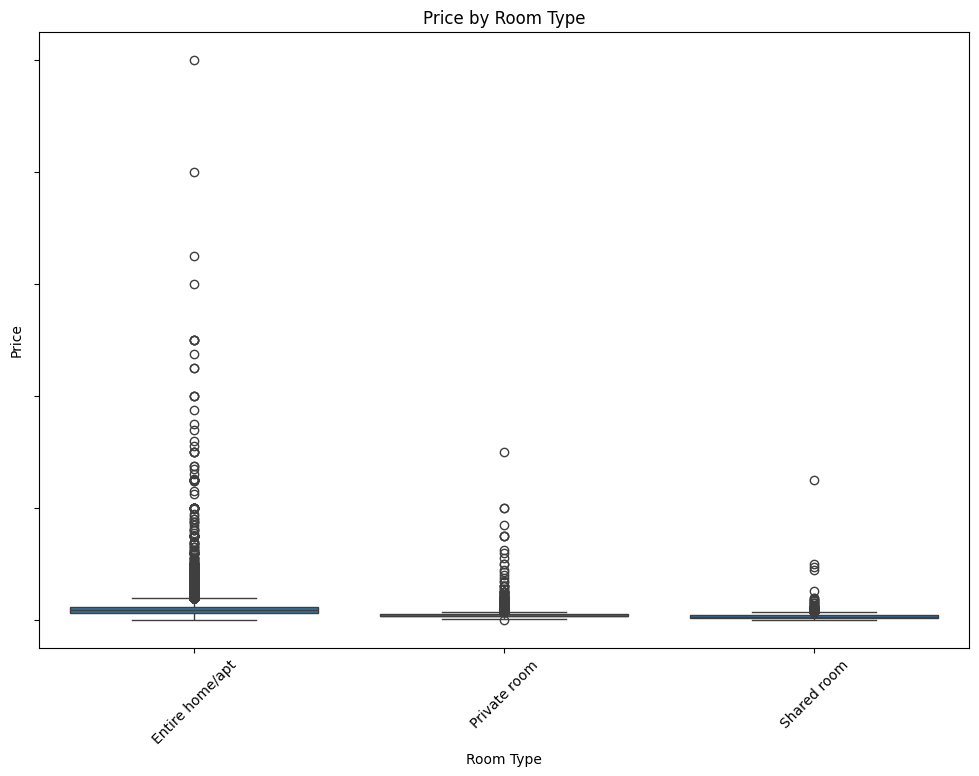

In [18]:
import matplotlib.ticker as mtick

df = pd.read_csv('airbnb_hw.csv', low_memory=False)
print(df.info())
print(df.describe())
print(df.head())
df = df.dropna(subset=['Price'])
df['Price'] = pd.to_numeric(df['Price'].replace('[\$,]', '', regex=True), errors='coerce')

# Visualize distributions of numerical variables
plt.figure(figsize=(8, 6))
sns.histplot(df['Price'])
plt.title('Distribution of Price')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

#log price
plt.figure(figsize=(8, 6))
sns.histplot(np.log(df['Price']))
plt.title('Distribution of log Price')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

# Box plot to visualize price by categorical variables
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='Room Type', y='Price')
plt.title('Price by Room Type')
plt.xticks(rotation=45, fontsize=10)
plt.gca().set_yticklabels([])
plt.show()


In [12]:
missing_counts = df.isnull().sum()
print("Missing values in each column:\n", missing_counts[missing_counts > 0])

Missing values in each column:
 Host Since                       3
Property Type                    3
Review Scores Rating (bin)    8323
Zipcode                        134
Beds                            85
Review Scores Rating          8323
dtype: int64


In [19]:
df['Host Since'] = df['Host Since'].fillna('Unknown')
df['Property Type'] = df['Property Type'].fillna(df['Property Type'].mode()[0])
df['Review Scores Rating (bin)'] = df['Review Scores Rating (bin)'].fillna(df['Review Scores Rating (bin)'].median())
df['Zipcode'] = df['Zipcode'].fillna(df['Zipcode'].mode()[0])
df['Beds'] = df['Beds'].fillna(df['Beds'].median())
df['Review Scores Rating'] = df['Review Scores Rating'].fillna(df['Review Scores Rating'].median())

print("Missing values after imputation:\n", df.isnull().sum())

Missing values after imputation:
 Host Id                       0
Host Since                    0
Name                          0
Neighbourhood                 0
Property Type                 0
Review Scores Rating (bin)    0
Room Type                     0
Zipcode                       0
Beds                          0
Number of Records             0
Number Of Reviews             0
Price                         0
Review Scores Rating          0
dtype: int64


In [20]:
# Log transformation for Price
df['Log_Price'] = np.log(df['Price'] + 1)  # Adding 1 to avoid log(0)
df = df.drop(columns=['Host Id', 'Host Since', 'Name'])

# One-hot encoding for categorical variables
categorical_features = ['Neighbourhood ', 'Property Type', 'Room Type']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)



In [21]:
X = df.drop(columns=['Log_Price'])
y = df['Log_Price']

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
y = df['Log_Price']
X = df.drop(columns=['Log_Price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg = linear_model.LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_hat = reg.predict(X_test)
r_squared = reg.score(X_test, y_test)  # R^2
rmse = np.sqrt(mean_squared_error(y_test, y_hat))  # RMSE

print('R^2: ', r_squared)
print('RMSE: ', rmse)
results = pd.DataFrame({'variable': reg.feature_names_in_, 'coefficient': reg.coef_})
print(results)

X2 = df.loc[:, df.columns.str.contains('Review Scores Rating|Beds|Neighbourhood_|Number Of Reviews|Property Type|Room Type')]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y,
                                                         test_size=0.2,
                                                         random_state=42)

reg2 = linear_model.LinearRegression(fit_intercept=False).fit(X_train2, y_train2)
y_hat2 = reg2.predict(X_test2)
r_squared2 = reg2.score(X_test2, y_test2)  # R^2
rmse2 = np.sqrt(mean_squared_error(y_test2, y_hat2))  # RMSE

print('R^2 for Model 2: ', r_squared2)
print('RMSE for Model 2: ', rmse2)
results2 = pd.DataFrame({'variable': reg2.feature_names_in_, 'coefficient': reg2.coef_})
print(results2)


R^2:  0.7646147451413264
RMSE:  0.30874578437334366
                         variable  coefficient
0      Review Scores Rating (bin)    -0.009009
1                         Zipcode    -0.000001
2                            Beds     0.078819
3               Number of Records     3.940598
4               Number Of Reviews    -0.000439
5                           Price     0.001530
6            Review Scores Rating     0.014073
7         Neighbourhood _Brooklyn     0.206443
8        Neighbourhood _Manhattan     0.432416
9           Neighbourhood _Queens     0.105888
10   Neighbourhood _Staten Island    -0.034564
11  Property Type_Bed & Breakfast     0.039326
12             Property Type_Boat    -0.038720
13         Property Type_Bungalow     0.043848
14            Property Type_Cabin     0.121565
15        Property Type_Camper/RV    -0.491966
16           Property Type_Castle     0.338885
17           Property Type_Chalet     0.256853
18      Property Type_Condominium     0.127602
19      

Model 1 is a better predictor

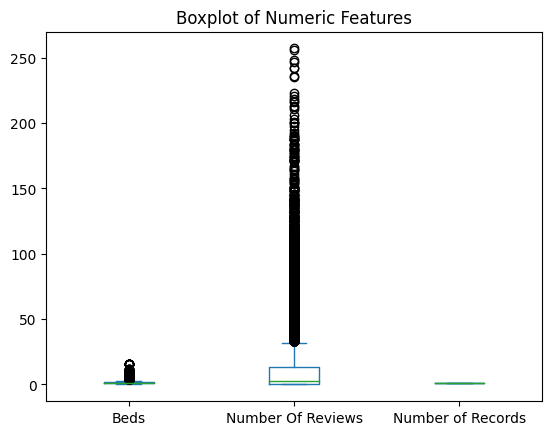

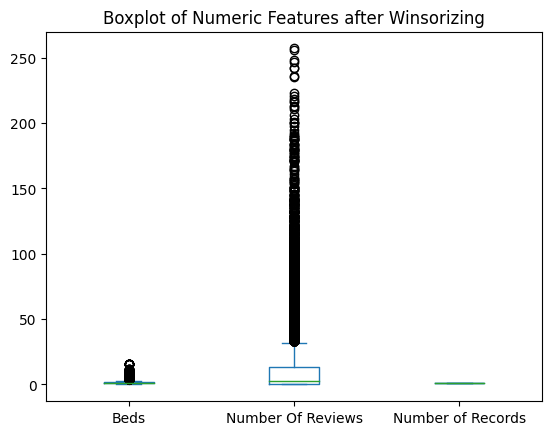

R-squared:  0.7660605874842847
RMSE:  0.3077960958808168
                               variable  coefficient
0                                  Beds     0.042132
1                     Number Of Reviews     0.000116
2                     Number of Records     1.288599
3                                Beds^2    -0.006069
4                Beds Number Of Reviews    -0.000292
5                Beds Number of Records     0.042132
6                   Number Of Reviews^2    -0.000003
7   Number Of Reviews Number of Records     0.000116
8                   Number of Records^2     1.288599
9            Review Scores Rating (bin)    -0.009128
10                              Zipcode    -0.000002
11                                 Beds     0.042132
12                    Number of Records     1.288599
13                    Number Of Reviews     0.000116
14                                Price     0.001528
15                 Review Scores Rating     0.014340
16              Neighbourhood _Brooklyn   

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import mstats


df.loc[:, ['Beds', 'Number Of Reviews', 'Number of Records']].plot.box()
plt.title('Boxplot of Numeric Features')
plt.show()
df[['Beds', 'Number Of Reviews', 'Number of Records']] = df[['Beds', 'Number Of Reviews', 'Number of Records']].apply(mstats.winsorize)
df.loc[:, ['Beds', 'Number Of Reviews', 'Number of Records']].plot.box()
plt.title('Boxplot of Numeric Features after Winsorizing')
plt.show()

numeric_features = ['Beds', 'Number Of Reviews', 'Number of Records']
expander = PolynomialFeatures(degree=2, include_bias=False)
X_num = df[numeric_features]
Z_num = expander.fit_transform(X_num)
names = expander.get_feature_names_out(numeric_features)
X_num = pd.DataFrame(data=Z_num, columns=names)

X_cat = df.drop(columns=['Log_Price'])
X = pd.concat([X_num, X_cat], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
results = pd.DataFrame({'variable': reg.feature_names_in_, 'coefficient': reg.coef_})
r_squared = reg.score(X_test, y_test)
y_hat = reg.predict(X_test)
rmse = np.sqrt(np.mean((y_test - y_hat) ** 2))

print('R-squared: ', r_squared)
print('RMSE: ', rmse)
print(results)


My complex model performs about the same as my linear model, possibly indiciating the linear model is already good enough or that I need to transform other variables besides the 3 I picked and also transform the variables in different ways.

6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?

I learned that using degrees to add complexity and expand the feature space may help with making better predictions but it can easily lead to overfitting. Likewise, sometimes a linear model works perfectly well but it may also be underfitting and not accounting for the variance in data properly. When selecting a model, it is important to consider the variables relationship to what we are trying to predict and make sure we are selecting an appropriately complex model for our needs.